In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
api_key = '6feb8c26f0ebddbc4a47b6cfeac77054'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=CPALTT01CLM657N&api_key={api_key}&observation_start=1980-01-01&observation_end=2022-12-01&frequency=m&file_type=json'
response = requests.get(url)

In [3]:
json_data = response.json()

In [4]:
data = [(obs["date"], obs["value"]) for obs in json_data["observations"]]
df = pd.DataFrame(data, columns=["date", "Inflation Rate Chile"])
df["date"] = pd.to_datetime(df["date"])
df["Inflation Rate Chile"] = df["Inflation Rate Chile"].astype("float")
df.index = df["date"]
df = df.drop("date", axis = 1)
df.dropna()
df

,Inflation Rate Chile
date,
1980-01-01,2.131044
1980-02-01,1.825737
1980-03-01,2.942187
1980-04-01,2.535319
1980-05-01,2.315210
...,...
2022-08-01,1.216173
2022-09-01,0.859394
2022-10-01,0.520710


In [5]:
df.index.freq = "MS"

Text(0, 0.5, 'Inflation Rate (Percentage Variation of CPI)')

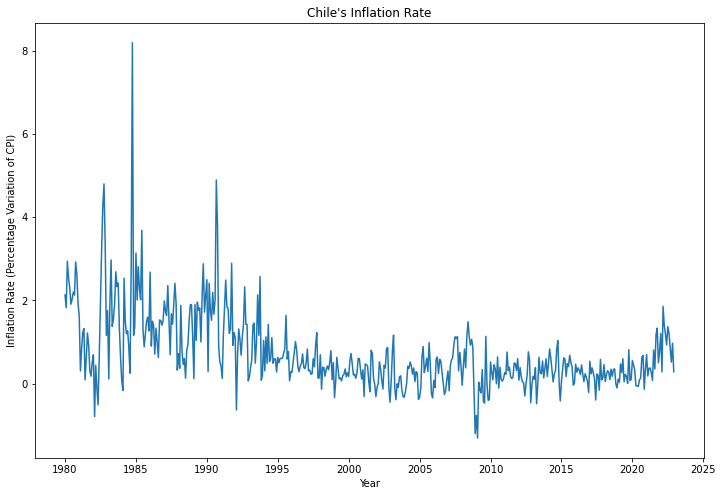

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(df['Inflation Rate Chile'])
plt.title("Chile's Inflation Rate")
plt.xlabel('Year')
plt.ylabel('Inflation Rate (Percentage Variation of CPI)')

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df['Inflation Rate Chile'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.150652
p-value                   0.023025
# lags used              12.000000
# observations          503.000000
critical value (1%)      -3.443418
critical value (5%)      -2.867303
critical value (10%)     -2.569840
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [9]:
len(df)

516

In [10]:
q_80 = int(len(df) * .8)

In [11]:
y_train = df["Inflation Rate Chile"].iloc[:q_80]
y_test = df["Inflation Rate Chile"].iloc[q_80:]

<AxesSubplot:xlabel='date'>

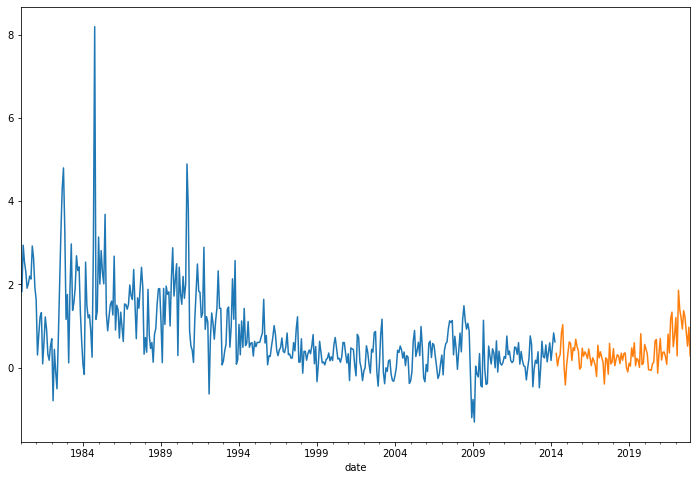

In [12]:
y_train.plot(figsize = (12, 8))
y_test.plot()

In [13]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
model = auto_arima(y_train, trace = True, seasonal = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1015.871, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=961.871, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=924.174, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1013.879, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=937.941, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=877.276, Time=0.39 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=916.205, Time=0.15 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=879.265, Time=1.38 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=879.266, Time=1.27 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=902.604, Time=0.44 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=894.981, Time=0.39 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=880.143, Time=1.11 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=957.694, Time=0.32 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept 

Potential models are: 
- ARIMA(2,1,3)x(1,0,1,12)
- ARIMA(4,1,1)x(1,0,1,12)
- ARIMA(4,1,2)x(1,0,1,12)
- ARIMA(3,1,3)x(1,0,1,12)

In [15]:
model_list = {"order": [(2, 1, 3), (4, 1, 1), (4, 1 ,2), (3, 1 ,3)], "seasonal_order": [(1,0,1,12), (1,0,1,12), (1,0,1,12), (1,0,1,12)]}

In [16]:
from statsmodels.tools.eval_measures import rmse

In [17]:
metrics = pd.DataFrame(data = {"Order" : [], "Seasonal Order": [], "AIC": [], "BIC" : [], "RMSE": []})
for order, seasonal_order in zip(model_list["order"], model_list["seasonal_order"]):
    model= SARIMAX(y_train, order = order, seasonal_order = seasonal_order, enforce_invertibility = True).fit()
   
    start = len(y_train)
    end = len(y_train) + len(y_test) -1
    
    y_pred = model.predict(start, end)
    rmse_model = rmse(y_test, y_pred)
    
    metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_10016\500163460.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_10016\500163460.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_1

In [18]:
metrics = metrics.sort_values("RMSE")
metrics

,Order,Seasonal Order,AIC,BIC,RMSE
3,"(3, 1, 3)","(1, 0, 1, 12)",833.701896,869.869235,0.434476
1,"(4, 1, 1)","(1, 0, 1, 12)",833.578127,865.726873,0.441829
2,"(4, 1, 2)","(1, 0, 1, 12)",833.624416,869.791755,0.442825
0,"(2, 1, 3)","(1, 0, 1, 12)",832.644443,864.793189,0.447645


The best model is SARIMA(3,1,3)x(1,0,1,12)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='date'>

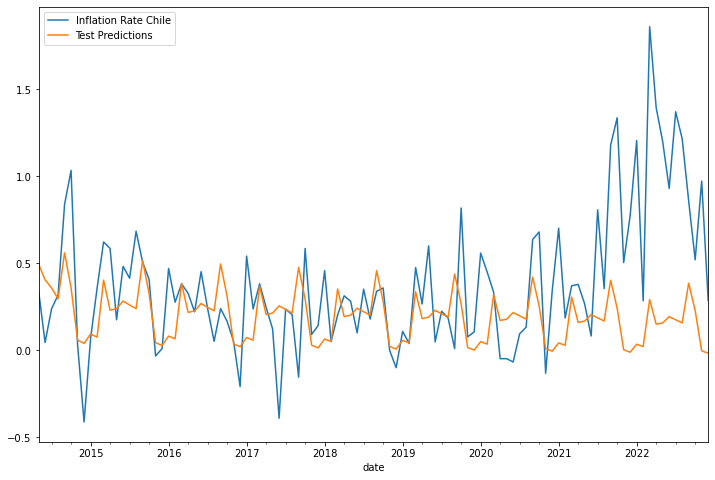

In [19]:
selected_model = SARIMAX(y_train, order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True).fit()
y_hat_test = selected_model.predict(start, end).rename("Test Predictions")
plt.figure(figsize = (12, 8))
y_test.plot(legend = True)
y_hat_test.plot(legend = True)

In [20]:
final_model =  SARIMAX(df["Inflation Rate Chile"], order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True).fit()
final_model.summary()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                 Inflation Rate Chile   No. Observations:                  516
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -466.458
Date:                              Fri, 02 Jun 2023   AIC                            950.916
Time:                                      01:03:29   BIC                            989.114
Sample:                                  01-01-1980   HQIC                           965.886
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1957      0.240     -0.815      0.415      -0.666       0.275
ar.L2          0.1498      0.156      0.958      0.338      -0.157       0.456
ar.L3          0.2047      0.083      2.465      0.014       0.042       0.367
ma.L1         -0.3230      0.238     -1.359      0.174      -0.789       0.143
ma.L2         -0.5369      0.159     -3.368      0.001      -0.849      -0.224
ma.L3         -0.0942      0.201     -0.467      0.640      -0.489       0.301
ar.S.L12       0.9785      0.014     68.828      0.000       0.951       1.006
ma.S.L12      -0.8804      0.043    -20.372      0.000      -0.965      -0.796
sigma2         0.3515      0.013     26.380      0.000       0.325       0.378
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6070.80
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_size = 12

In [22]:
final_order  = metrics["Order"].iloc[0]
final_seasonal_order = metrics["Seasonal Order"].iloc[0]

In [23]:
y_forecast = final_model.predict(start = len(df), end = len(df) + forecast_size - 1, typ = "levels").rename(f"SARIMA{final_order}x{final_seasonal_order} Forecast")

<AxesSubplot:xlabel='date'>

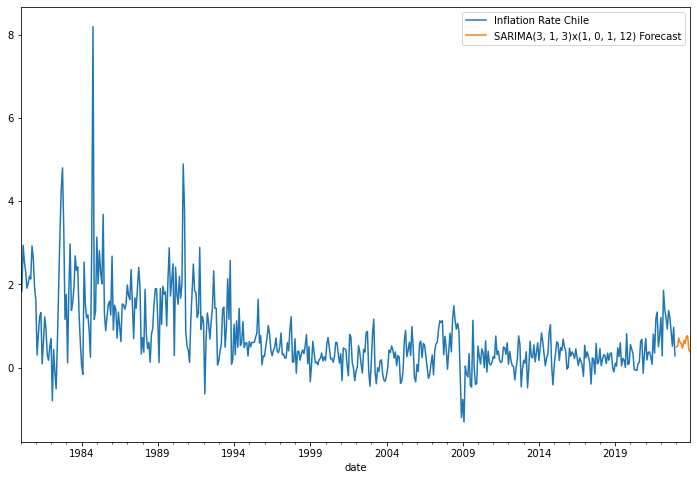

In [24]:
plt.figure(figsize = (12, 8))
df["Inflation Rate Chile"].plot(legend = True)
y_forecast.plot(legend = True)

<AxesSubplot:xlabel='date'>

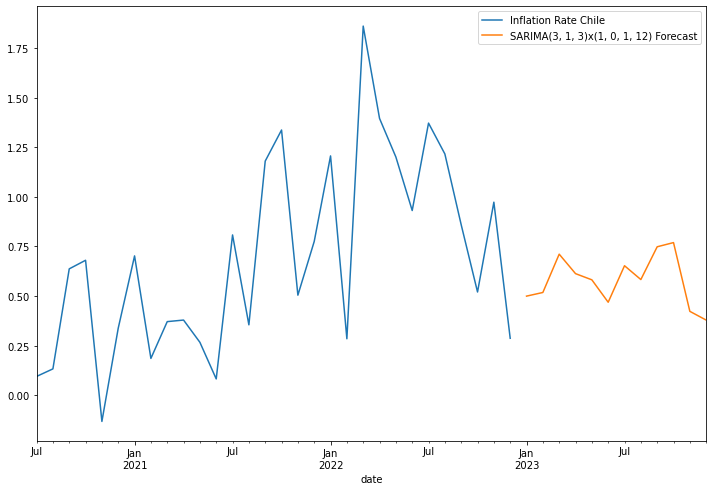

In [25]:
plt.figure(figsize = (12, 8))
df["Inflation Rate Chile"].iloc[-30:].plot(legend = True)
y_forecast.plot(legend = True)

In [26]:
y_forecast

2023-01-01    0.499926
2023-02-01    0.518261
2023-03-01    0.711337
2023-04-01    0.613235
2023-05-01    0.582058
2023-06-01    0.469114
2023-07-01    0.653072
2023-08-01    0.583420
2023-09-01    0.748511
2023-10-01    0.769653
2023-11-01    0.423210
2023-12-01    0.379238
Freq: MS, Name: SARIMA(3, 1, 3)x(1, 0, 1, 12) Forecast, dtype: float64